In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.stats import norm

from tqdm.auto import tqdm

plt.style.use('ggplot')
%matplotlib inline

## Задача
#### Нужно понять, стали ли мы больше зарабатывать с пользователя или нет.

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев.

P.S. Понятно, что в реальной жизни не стоит сравнивать p-value разных критериев, тк это повышает вероятность допустить ошибку 1 рода.

In [2]:
df = pd.read_csv('hw_bootstrap.csv', sep=';',decimal=',')

In [3]:
df.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [4]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [5]:
df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [6]:
df.value_counts('experimentVariant')

experimentVariant
Treatment    500
Control      500
dtype: int64

In [7]:
df.groupby('experimentVariant').value.agg({'mean', 'median'})

,median,mean
experimentVariant,,
Control,10.018465,10.026867
Treatment,10.025847,27.321499


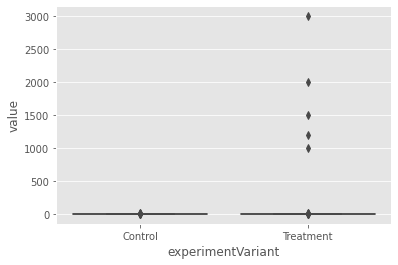

In [8]:
sns.boxplot(x = 'experimentVariant', y = 'value', data = df)

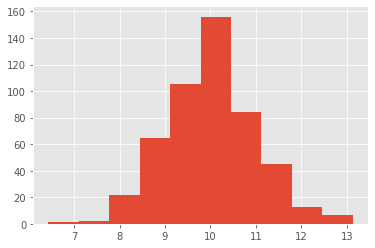

In [9]:
df[df.experimentVariant == 'Control'].value.hist()

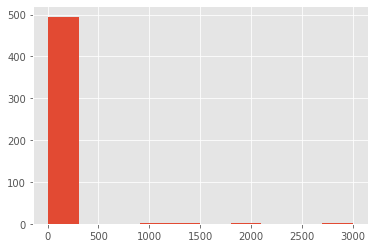

In [10]:
df[df.experimentVariant == 'Treatment'].value.hist()

In [11]:
df.sort_values('value', ascending = False).head(10)

,Unnamed: 0,value,experimentVariant
999,1000,3000.000000,Treatment
998,999,2000.000000,Treatment
997,998,1500.000000,Treatment
996,997,1200.000000,Treatment
995,996,1000.000000,Treatment
171,172,13.130346,Control
671,672,13.130346,Treatment
195,196,12.817541,Control
695,696,12.817541,Treatment
294,295,12.728285,Control


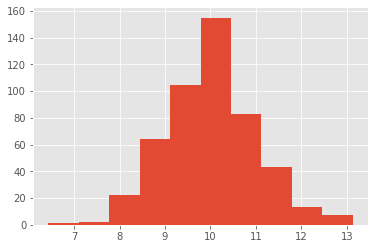

In [12]:
df.query("experimentVariant == 'Treatment' and value < 1000").value.hist()

In [13]:
df_1000 = df.query('value < 1000')

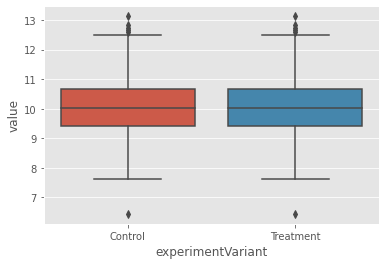

In [14]:
sns.boxplot(x = 'experimentVariant', y = 'value', data = df_1000)

### t тест с исходными датасетом

In [15]:
st.ttest_ind(df[df.experimentVariant == 'Control'].value, df[df.experimentVariant == 'Treatment'].value)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

### t тест без выбросов

In [16]:
st.ttest_ind(df_1000[df_1000.experimentVariant == 'Control'].value, df_1000[df_1000.experimentVariant == 'Treatment'].value)

Ttest_indResult(statistic=0.0829913510759266, pvalue=0.9338751428058369)

### Манна-Уитни тест

In [17]:
st.mannwhitneyu(df[df.experimentVariant == 'Control'].value, df[df.experimentVariant == 'Treatment'].value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [3]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Bootstrap на основной выборке

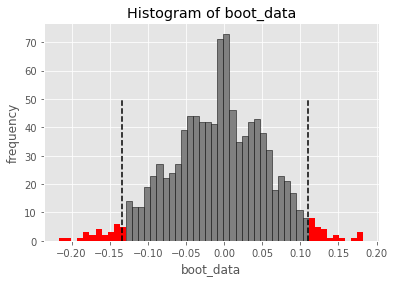

In [19]:
booted_df = get_bootstrap(df[df.experimentVariant == 'Control'].value, df[df.experimentVariant == 'Treatment'].value)

In [20]:
booted_df['p_value']

0.9029837080359728

In [21]:
booted_df['quants']

,0
0.025,-0.133480
0.975,0.110466


### С помощью критерия Левена проверим различия в дисперсиях

In [22]:
st.levene(df[df.experimentVariant == 'Control'].value, df[df.experimentVariant == 'Treatment'].value)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

In [23]:
np.var(df[df.experimentVariant == 'Control'].value)

0.9572617077286163

In [24]:
np.var(df[df.experimentVariant == 'Treatment'].value)

34733.91141330792

### p < 0.05, следовательно верна альтернативная гипотеза о том, что дисперсии значимо отличаются в выборках. 

# Результат: p value > 0.05, не отклоняем нулевую гипотезу. Выборки стат.значимо не различаются. 


# Выводы:


### t тест на исходных данных применять не следует, так как присутствуют значительные выбросы. С помощью критерия Левена зафиксированы стат. значимые различия в дисперсиях.


### U тест применять на исходных данных можно, но из-за дальнейшних проблем с интерпретацей данного теста лучше находить более легкий для перевода на бизнес язык тест


### Bootstrap. Из-за сильно выраженных выбросов в исходных данных, корректно применить bootstrap возможно, извлекая из бутстрап-подвыборок медианные значения.